# Lasso Regression

In this notebook, we shall delve into the practical application of the Least Absolute Shrinkage and Selection Operator, commonly abbreviated as LASSO. Our objective is to assess its efficacy in two separate scenarios: one involving irregular coefficients and another with regular coefficients.

Though ridge regression has a great many applications and uses, there is one thing to note: it does not perform variable selection.

Lasso regression aids in variable selection and can entirely nullify certain coefficients. However, does this methodology perform equally effectively in the two aforementioned scenarios?
 
we will generate artificial datasets to illustrate and evaluate the functionality of Lasso regression. One dataset will be intentionally designed to exhibit multicollinearity, a situation where the explanatory variables are highly correlated with one another, posing a challenge for traditional regression techniques. The other dataset will be structured with a regular matrix of explanatory variables, representing a scenario where relationships between variables adhere to more conventional patterns. By applying Lasso regression to these two distinct datasets, we aim to examine its performance in variable selection and coefficient estimation under both scenarios, shedding light on its versatility and effectiveness in handling diverse real-world data complexities.

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

RSEED = 0

# define figure size
plt.rcParams['figure.figsize'] = (10, 7)

In [114]:
# Create Variables
seed_value = 42
np.random.seed(seed_value)

# Independent Variables
X1 = 2 * np.random.rand(500,1)
X2 = np.random.normal(30, 20, (500,1))
X3 = np.random.gamma(2, 5, (500, 1))
X4 = -0.5 * np.random.rand(500,1)
X5 = 3 * np.random.normal(50, 60, (500,1))
X6 = np.random.normal(0, 1, (500,1))

# Variables that are linear combination of X1 - X6 variables
X7 = 4 + 0.95 * X1
X8 = 0.98 * X5
X9 = -0.99 * X3
X10 = 18 - 0.80 * X6
X11 = 0.75 * X1
X12 = 0.97 * X2

# Variables that are not linear combination of X1-X6 variables
X13 = 0.25 * X2**2
X14 = 10 + X4**3
X15 = -0.19 * X3 
X16 = 0.20 * X6
X17 = 45 + 0.15 * X1**0.7
X18 = 0.35 * np.abs(X5)**0.8

# Dependent Variables
noise1 = np.random.normal(0, 1, (500, 1)) 

y1 = 10 + 2*X1 + 5*X2 + 0.5*X3 + 20*X4 + 3*X5 + 40*X6 + 22*X7 + 0.85*X8 + 6.5*X9 + 2*X12 + 23*X13 + 4*X18 + noise1



In [115]:
# Create a DataFrame with multicolinearity
data_1 = {
    'X1': X1.flatten(),
    'X2': X2.flatten(),
    'X3': X3.flatten(),
    'X4': X4.flatten(),
    'X5': X5.flatten(),
    'X6': X6.flatten(),
    'X7': X7.flatten(),
    'X8': X8.flatten(),
    'X9': X9.flatten(),
    'X10': X10.flatten(),
    'X11': X11.flatten(),
    'X12': X12.flatten(),
    'X13': X13.flatten(),
    'X14': X14.flatten(),
    'X15': X15.flatten(),
    'X16': X16.flatten(),
    'X17': X17.flatten(),
    'X18': X18.flatten(),
    'y1': y1.flatten()
}

df_colinear = pd.DataFrame(data_1)

df_colinear.head()


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,y1
0,0.749080,36.835120,12.699421,-0.043546,34.532356,0.622070,4.711626,33.841709,-12.572426,17.502344,0.561810,35.730066,339.206507,9.999917,-2.412890,0.124414,45.122535,5.951809,8276.977589
1,1.901429,67.523417,6.222611,-0.308533,237.817011,1.328933,5.806357,233.060671,-6.160385,16.936853,1.426071,65.497714,1139.852954,9.970630,-1.182296,0.265787,45.235205,27.865214,27860.279402
2,1.463988,49.008477,14.830738,-0.056919,474.782660,0.386809,5.390788,465.287007,-14.682431,17.690553,1.097991,47.538222,600.457699,9.999816,-2.817840,0.077362,45.195870,48.446669,16222.298535
3,1.197317,18.461927,12.055376,-0.172612,115.637317,1.090980,5.137451,113.324571,-11.934822,17.127216,0.897988,17.908069,85.210686,9.994857,-2.290521,0.218196,45.170152,15.651157,2688.296353
4,0.312037,12.031707,20.817823,-0.253706,279.556430,2.012270,4.296435,273.965301,-20.609645,16.390184,0.234028,11.670755,36.190491,9.983670,-3.955386,0.402454,45.066380,31.713460,2171.505829


In [116]:
noise2 = np.random.normal(0, 1, (500, 1)) 
y2 = 34 + 12*X1 + 5*X3 + 13*X4 + 16*X6 + 33*X13 + 4*X18 + noise2

In [117]:
# Create a DataFrame without multicolinearity
data_2 = {
    'X1': X1.flatten(),
    'X2': X2.flatten(),
    'X3': X3.flatten(),
    'X4': X4.flatten(),
    'X5': X5.flatten(),
    'X6': X6.flatten(),
    'X7': X7.flatten(),
    'X8': X8.flatten(),
    'X9': X9.flatten(),
    'X10': X10.flatten(),
    'X11': X11.flatten(),
    'X12': X12.flatten(),
    'X13': X13.flatten(),
    'X14': X14.flatten(),
    'X15': X15.flatten(),
    'X16': X16.flatten(),
    'X17': X17.flatten(),
    'X18': X18.flatten(),
    'y2': y2.flatten()
}

df_normal = pd.DataFrame(data_2)

df_normal.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,y2
0,0.749080,36.835120,12.699421,-0.043546,34.532356,0.622070,4.711626,33.841709,-12.572426,17.502344,0.561810,35.730066,339.206507,9.999917,-2.412890,0.124414,45.122535,5.951809,11334.428193
1,1.901429,67.523417,6.222611,-0.308533,237.817011,1.328933,5.806357,233.060671,-6.160385,16.936853,1.426071,65.497714,1139.852954,9.970630,-1.182296,0.265787,45.235205,27.865214,37831.567801
2,1.463988,49.008477,14.830738,-0.056919,474.782660,0.386809,5.390788,465.287007,-14.682431,17.690553,1.097991,47.538222,600.457699,9.999816,-2.817840,0.077362,45.195870,48.446669,20141.126436
3,1.197317,18.461927,12.055376,-0.172612,115.637317,1.090980,5.137451,113.324571,-11.934822,17.127216,0.897988,17.908069,85.210686,9.994857,-2.290521,0.218196,45.170152,15.651157,2999.866305
4,0.312037,12.031707,20.817823,-0.253706,279.556430,2.012270,4.296435,273.965301,-20.609645,16.390184,0.234028,11.670755,36.190491,9.983670,-3.955386,0.402454,45.066380,31.713460,1490.955429


In [118]:
# define features for the model 1
features_1 = df_colinear.columns.tolist()
features_1.remove('y1')
X_1 = df_colinear[features_1]
y_1 = df_colinear['y1']

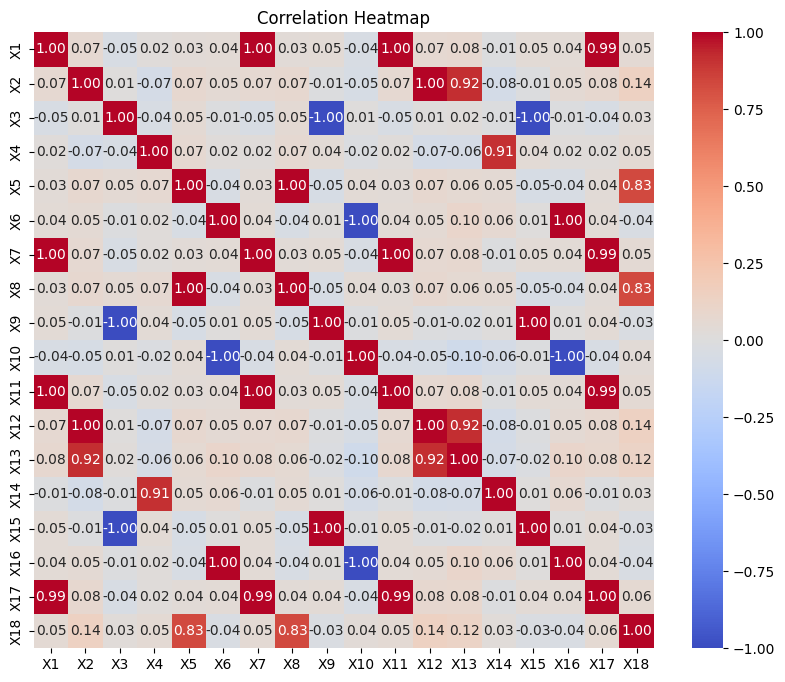

In [119]:
corr_matrix = X_1.corr()

plt.figure(figsize=(10, 8)) 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")  
plt.title("Correlation Heatmap")  
plt.show()  

In [120]:
# define features for the model 2
features_2 = df_normal.columns.tolist()
features_2.remove('y2')
X_2 = df_normal[features_2]
y_2 = df_normal['y2']

In [121]:
# train-test-split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, random_state=RSEED, test_size=0.4)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, random_state=RSEED, test_size=0.4)
print(X_train_1.shape)
print(X_train_2.shape)

(300, 18)
(300, 18)


In [122]:
from sklearn.linear_model import LinearRegression

# initialize and train model
lin_reg_1 = LinearRegression()
lin_reg_2 = LinearRegression()
lin_reg_1.fit(X_train_1, y_train_1)
lin_reg_2.fit(X_train_2, y_train_2)

# predict on test-set
y_pred_test_1 = lin_reg_1.predict(X_test_1)
y_pred_train_1 = lin_reg_1.predict(X_train_1)
y_pred_test_2 = lin_reg_2.predict(X_test_2)
y_pred_train_2 = lin_reg_2.predict(X_train_2)

# RMSE on train and test set
print("Train RMSE Model 1:", round(np.sqrt(mean_squared_error(y_train_1, y_pred_train_1)), 3))
print("Test RMSE Model 1:", round(np.sqrt(mean_squared_error(y_test_1, y_pred_test_1)), 3))
print("Train RMSE Model 2:", round(np.sqrt(mean_squared_error(y_train_2, y_pred_train_2)), 3))
print("Test RMSE Model 2:", round(np.sqrt(mean_squared_error(y_test_2, y_pred_test_2)), 3))

Train RMSE Model 1: 1.027
Test RMSE Model 1: 1.045
Train RMSE Model 2: 1.01
Test RMSE Model 2: 0.979


# Note:

RMSE provides a single number that summarizes how well a predictive model is performing. Lower RMSE values indicate better model performance because they indicate that the model's predictions are closer to the actual values on average. RMSE is widely used in various fields, including machine learning, statistics, and economics, to evaluate the accuracy of predictive models and to compare different models or algorithms.

RMSE = $\sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$

In [123]:
def coeff_info(model):
    coeff_used = np.sum(model.coef_!=0)
    print('The model is using', coeff_used, 'out of 18 features.')
    print( "The highest coefficient has a value of:", max(model.coef_.round(3)))

In [124]:
print('Model 1:')
coeff_info(lin_reg_1)

print('Model 2:')
coeff_info(lin_reg_2)

Model 1:
The model is using 18 out of 18 features.
The highest coefficient has a value of: 23.793
Model 2:
The model is using 18 out of 18 features.
The highest coefficient has a value of: 33.0


In [125]:
from sklearn.linear_model import Lasso

In [126]:
# initialize and train model with (default value) alpha = 0.5
lasso_05_1 = Lasso(alpha=0.5, max_iter=int(10e5))
lasso_05_1.fit(X_train_1,y_train_1)

# predict on test-set
y_pred_test_lasso_1 = lasso_05_1.predict(X_test_1)
y_pred_train_lasso_1 = lasso_05_1.predict(X_train_1)

# RMSE of test set
print("Train RMSE:", round(np.sqrt(mean_squared_error(y_train_1, y_pred_train_lasso_1)), 3))
print("Test  RMSE:", round(np.sqrt(mean_squared_error(y_test_1, y_pred_test_lasso_1)), 3))


Train RMSE: 3.207
Test  RMSE: 3.214


In [127]:
print('Model 1:')
coeff_info(lasso_05_1)

Model 1:
The model is using 10 out of 18 features.
The highest coefficient has a value of: 39.634


In [128]:
# Get the coefficients and variable names
coefficients_1 = lasso_05_1.coef_
variable_names = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']

# Print the non-zero coefficients and their corresponding variable names
selected_variables = [var for coef, var in zip(coefficients_1, variable_names) if coef != 0]
print("Selected Variables in the Model 1:", selected_variables)

Selected Variables in the Model 1: ['X1', 'X2', 'X3', 'X5', 'X6', 'X8', 'X9', 'X12', 'X13', 'X18']


In [129]:
# initialize and train model with (default value) alpha = 0.5
lasso_05_2 = Lasso(alpha=0.5, max_iter=int(10e5))
lasso_05_2.fit(X_train_2,y_train_2)

# predict on test-set
y_pred_test_lasso_2 = lasso_05_2.predict(X_test_1)
y_pred_train_lasso_2 = lasso_05_2.predict(X_train_1)

# RMSE of test set
print("Train RMSE:", round(np.sqrt(mean_squared_error(y_train_2, y_pred_train_lasso_2)), 3))
print("Test  RMSE:", round(np.sqrt(mean_squared_error(y_test_2, y_pred_test_lasso_2)), 3))

Train RMSE: 2.339
Test  RMSE: 2.255


In [130]:
print('Model 2:')
coeff_info(lasso_05_2)

Model 2:
The model is using 9 out of 18 features.
The highest coefficient has a value of: 33.001


In [131]:
# Get the coefficients and variable names
coefficients_2 = lasso_05_2.coef_
variable_names = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']

# Print the non-zero coefficients and their corresponding variable names
selected_variables = [var for coef, var in zip(coefficients_2, variable_names) if coef != 0]
print("Selected Variables in the Model 2:", selected_variables)

Selected Variables in the Model 2: ['X1', 'X2', 'X3', 'X5', 'X6', 'X8', 'X12', 'X13', 'X18']
